In [3]:
from typing_extensions import TypedDict
from IPython.display import Image, display 
from langgraph.graph import StateGraph, START, END 

class State(TypedDict):
    foo: int 


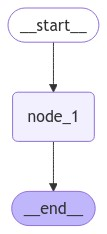

---Node 1---


{'foo': 2}

In [4]:
def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

builder = StateGraph(State)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo" : 1})

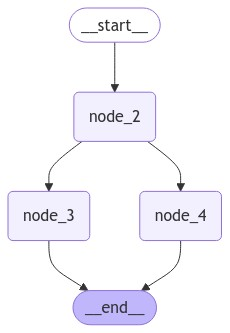

In [7]:
def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}
def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}
def node_4(state):
    print("---Node 4---")
    return {"foo": state['foo'] + 1}

builder = StateGraph(State)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)

builder.add_edge(START, "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_2", "node_4")
builder.add_edge("node_3", END)
builder.add_edge("node_4", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [8]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo": 0})
except InvalidUpdateError as e:
    print(f"Invalid update error occurred: {e}")

---Node 2---
---Node 3---
---Node 4---
Invalid update error occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.


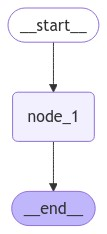

---Node 1---


{'foo': [1, 2]}

In [11]:
from typing import Annotated 
from operator import add

class AnnotatedState(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

builder = StateGraph(AnnotatedState)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo" : [1]})

In [14]:
def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}
def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}
def node_4(state):
    print("---Node 4---")
    return {"foo": [state['foo'][-1] + 1]}

builder = StateGraph(AnnotatedState)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)

builder.add_edge(START, "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_2", "node_4")
builder.add_edge("node_3", END)
builder.add_edge("node_4", END)

graph = builder.compile()

graph.invoke({"foo": [1]})

---Node 2---
---Node 3---
---Node 4---


{'foo': [1, 2, 3, 3]}

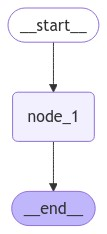

---Node 1---


{'foo': [2]}

In [15]:
def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]
    

def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo" : None})


In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str

class ExtendedMessagesState(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str





In [17]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I am looking for info on marine biology", name="Lance"),
                   ]


new_messages = AIMessage(content="I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_messages, new_messages)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='ced026f7-acf3-4fbf-a688-d742c9745b1b'),
 HumanMessage(content='I am looking for info on marine biology', additional_kwargs={}, response_metadata={}, name='Lance', id='0ae7f127-4ce2-46b1-8f1f-622eedd52e99'),
 AIMessage(content='I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='0adbdcdb-4ebc-4906-9eb0-f4a565b28d22')]

In [18]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id=1),
                    HumanMessage(content="I am looking for info on marine biology", name="Lance", id=2),
                   ]


new_messages = HumanMessage(content="I am looking for information on whales, specifically", name="Lance", id=2)

add_messages(initial_messages, new_messages)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content='I am looking for information on whales, specifically', additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

In [19]:
from langchain_core.messages import RemoveMessage

# Initial state
messages = [AIMessage(content="Hello! How can I assist you?", name="Bot", id=1)]
messages.append(HumanMessage(content="Hi.", name="Lance", id=2))
messages.append(AIMessage(content="You said you were researching ocean mammals?", name="Bot", id=3))
messages.append(HumanMessage(content="I know about whales, but what other should I know about?", name="Lance", id=4))

# Delete all but the 2 most recent messages
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)




[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [20]:
add_messages(messages, delete_messages)

[AIMessage(content='You said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='I know about whales, but what other should I know about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]